In [1]:
import gc
import math
from time import time_ns
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import numba as nb
from numba import cuda  # must be explicitly imported
from tqdm import tqdm

if False:  # numba unhappy when used with target=cuda
    sin = np.sin
    cos = np.cos
else:
    sin = math.sin
    cos = math.cos

COMPLEXITY = 2 ** 11

In [2]:
def base_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

def base(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = base_dummy(d[idx])
    return r

In [3]:
@nb.njit
def njited_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.njit
def njited(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_dummy(d[idx])
    return r

In [4]:
@nb.njit(inline = 'always')
def njited_inline_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.njit
def njited_inline(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in range(d.shape[0]):
        r[idx] = njited_inline_dummy(d[idx])
    return r

In [5]:
@nb.njit
def njited_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.njit(parallel = True)
def njited_parallel(d: np.ndarray) -> np.ndarray:
    r = np.zeros(d.shape, dtype = d.dtype)
    for idx in nb.prange(d.shape[0]):
        r[idx] = njited_parallel_dummy(d[idx])
    return r

In [6]:
@nb.njit
def vectorized_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize
def vectorized(d: float) -> float:
    return vectorized_dummy(d)

In [7]:
@nb.njit('f8(f8)')
def vectorized_parallel_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize('f8(f8)', target = 'parallel')
def vectorized_parallel(d: float) -> float:
    return vectorized_parallel_dummy(d)

In [8]:
# @nb.njit('f8(f8)') -> Untyped global name 'vectorized_cuda_dummy': using cpu function on device but its compilation is disabled
# @nb.vectorize('f8(f8)', target = 'cuda') > Untyped global name 'vectorized_cuda_dummy': Cannot determine Numba type of <class 'numba.cuda.dispatcher.CUDAUFuncDispatcher'>
@cuda.jit('f8(f8)', device = True, inline = True)
def vectorized_cuda_dummy(scalar: float) -> float:
    res: float = 0.0
    for idx in range(COMPLEXITY):
        if idx % 2 == round(scalar) % 2:
            res += sin(idx)
        else:
            res -= cos(idx)
    return res

@nb.vectorize('f8(f8)', target = 'cuda')
def vectorized_cuda(d: float) -> float:
    return vectorized_cuda_dummy(d)

In [9]:
funcs = [
    base,
    njited,
    njited_inline,
    njited_parallel,
    vectorized,
    vectorized_parallel,
    vectorized_cuda,
]

In [10]:
def test_all(size = 100):
    
    data = np.random.random(size) * 128
    res_base = funcs[0](data)
    
    for func in funcs[1:]:
        res = func(data)
        assert np.allclose(res_base, res)
        
test_all()

/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (1) < 2 * SM count (128) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [11]:
def _name(func):
    try:
        return func.__name__
    except AttributeError:  # numba#8272
        return list(func.functions.values())[0][1].py_func.__name__[13:]

def benchmark(start = 4, stop = 23, reps = 2):  # 16
    sizes = (2 ** np.arange(start, stop + 0.5, 0.5)).astype('i8')
    results = {_name(func): [] for func in funcs[1:]}
    gc.disable()
    for size in tqdm(sizes):
        data = np.arange(0, size, 1, dtype = 'f8')
        for func in funcs[1:]:  # exclude pure python
            runtimes = []
            for rep in range(reps):
                gc.collect()
                start = time_ns()
                _ = func(data)
                runtime = time_ns() - start
                runtimes.append(runtime)
            results[_name(func)].append(min(runtimes) * 1e-9)
    gc.enable()
    return sizes, results

s, r = benchmark()

 28%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                                                                                                                                                                | 11/39 [00:05<00:15,  1.81it/s]/home/ernst/Desktop/PROJEKTE/prj.TST2/github.poliastro/env310/lib/python3.10/site-packages/numba/cuda/compiler.py:726: NumbaPerformanceWarning: Grid size (2) < 2 * SM count (128) will likely result in GPU under utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
 33%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                            

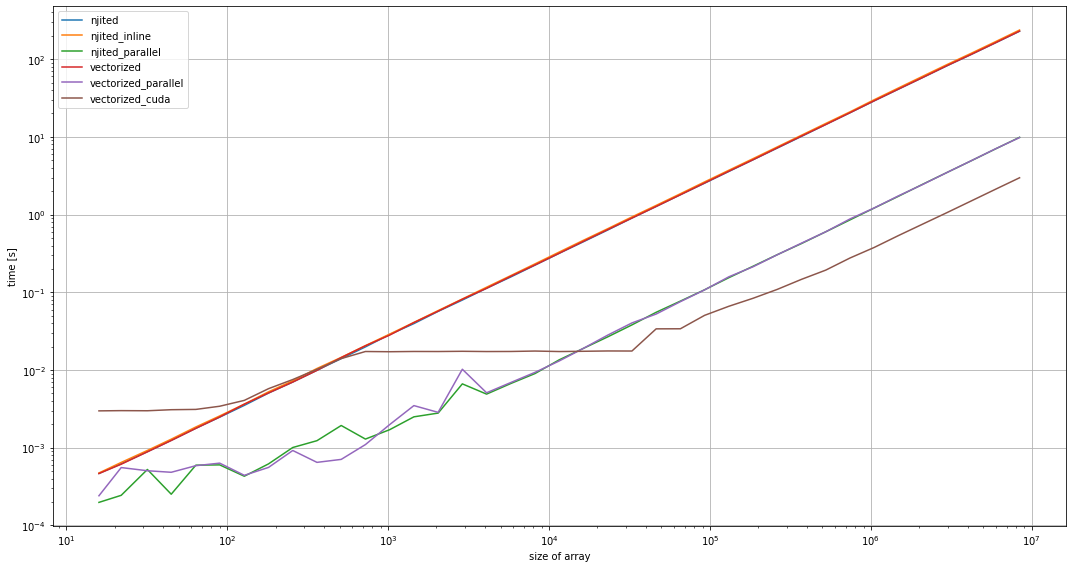

In [12]:
def plot_all(sizes, results):
    fig, ax = plt.subplots(figsize = (15, 8))
    for name, values in results.items():
        ax.loglog(sizes, values, label = name)
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('time [s]')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_all.jpg')

plot_all(s, r)

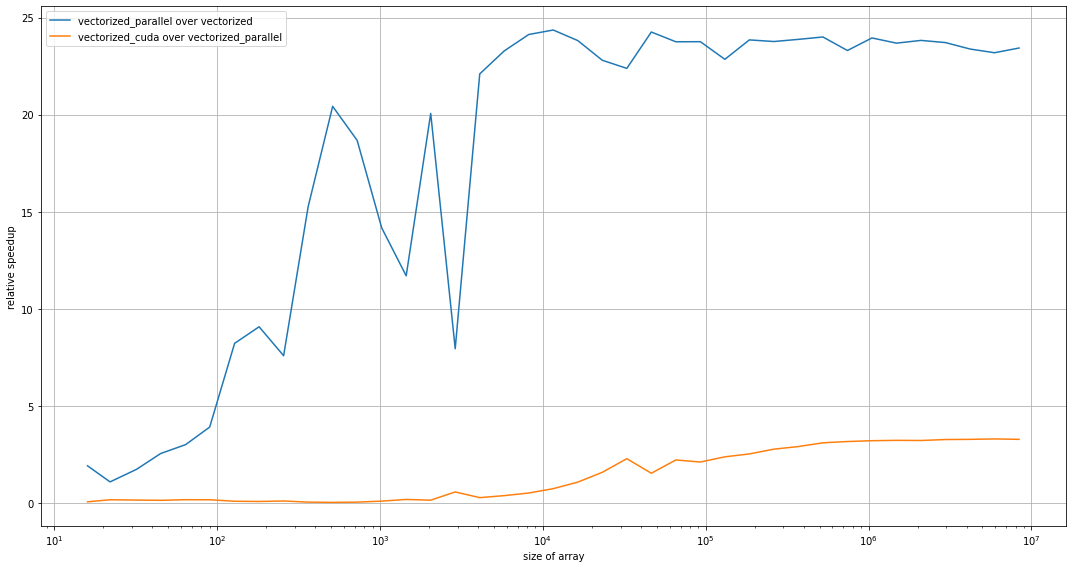

In [13]:
def plot_relative_speedup(sizes, results, pairs):
    fig, ax = plt.subplots(figsize = (15, 8))
    for base, faster in pairs:
        ax.semilogx(
            sizes,
            np.array(r[base]) / np.array(r[faster]),
            label = f'{faster:s} over {base:}',
        )
    ax.legend()
    ax.set_xlabel('size of array')
    ax.set_ylabel('relative speedup')
    ax.grid()
    fig.tight_layout()
    fig.savefig('plot_relative_speedup.jpg')

plot_relative_speedup(s, r, pairs = [
    ('vectorized', 'vectorized_parallel'),
    ('vectorized_parallel', 'vectorized_cuda'),
])

In [14]:
s

array([     16,      22,      32,      45,      64,      90,     128,
           181,     256,     362,     512,     724,    1024,    1448,
          2048,    2896,    4096,    5792,    8192,   11585,   16384,
         23170,   32768,   46340,   65536,   92681,  131072,  185363,
        262144,  370727,  524288,  741455, 1048576, 1482910, 2097152,
       2965820, 4194304, 5931641, 8388608])

In [15]:
pprint(r)

{'njited': [0.00046608200000000004,
            0.000621262,
            0.000888504,
            0.001243765,
            0.0017790170000000001,
            0.00247173,
            0.0035031940000000003,
            0.005048081,
            0.007001219,
            0.009921800000000001,
            0.014022636000000002,
            0.01982309,
            0.028612755,
            0.039537509000000005,
            0.056795548,
            0.07943224,
            0.11271890300000001,
            0.15754442400000002,
            0.223591969,
            0.317590186,
            0.44750428900000006,
            0.6331332740000001,
            0.9018749620000001,
            1.271493825,
            1.8007542950000002,
            2.536662789,
            3.589324806,
            5.0768979000000005,
            7.182482913,
            10.149991951,
            14.432900129,
            20.423478127000003,
            29.079588239000003,
            41.110390849000005,
            58.02083